# Separación de componentes con redes neuronals 
En este lab la idea es que separéis una señal en las distintas componentes que la consituyen. El caso que estudiaremos es el cielo en el rango de las microondas. La señal que nos llega es una mezcla de fondo cósmico de microondas (CMB), radiación debida al polvo térmico interestelar, y la radiación sincrotrón debida a partículas atravesando el campo magnético de nuestra Galaxia. Cuanto mejor las caractericemos, mejor las podremos estudiar, tanto para análisis cosmológicos (CMB) o para el estudio de nuestra Galaxia (sincrotrón y polvo). Así la señal que recibimos es a cada frecuencia $\nu$ es: 
\begin{equation}
S_{\nu}=S_{cmb}+S_{synch}+S_{dust}+noise
\end{equation}

Conocemos el modelo de como se comportan frecuencialmente estas componentes por separado y se puede caracterizar por 4 parámteros: Amplitud del Cmb ($A_{cmb}$), Amplitud del syncrotron e índice espectral del sincrotrón ($A_{s}$) y ($\beta_s$) y el polvo térmico con su amplitud a 353GHz $A_{d}$. 

Os vamos a dar tres data sets. Cada uno de ellos tendrá la señal (en K) con todas las componentes mezcladas más una contribución de ruido (debida a la sensibilidad del detector, cantidad de tiempo observado, etc.) y los 4 parámetros de las componentes: $A_{cmb}$, $A_{d}$ y $A_s$ y $\beta_s$ (detalles en la presentación):
* PLANCK:  9 frecuencias del satélite PLANCK de la ESA (30, 44, 70, 100, 143, 217, 353, 545, 857 GHZ).
* PLANCK + HASLAM : Añadimos un canal a muy baja frecuencia (0.408 GHz).

Los data sets los encontraréis en: SET+'_Signal_dataset.txt' y SET+'_Signal_labels.txt'

Trabajaremos con `healpy`, la parte de cargar mapas y visualizarlos está en este notebook. Podéis instalarlo con `pip install healpy`


# Ejercicio 1
   Buscaremos el mejor modelo para cada uno de los datasets y lo validaremos con uns simulación de mapas realistas
   *   **1.1.** Encuentra con una red neuronal un bueno modelo que relacione los inputs con los parámetros de las componentes para cada uno de los data sets.   
   *   **1.2.** Evalúa con una simulación independiente como de buenos son tus resultados. 
   *   **1.3.** Comenta qué parametros mejoran cuando añadimos una frecuencia más (más baja) y porqué. 

**(7 puntos)**

In [1]:
!pip install healpy

     |████████████████████████████████| 11.8MB 2.6MB/s 


In [2]:
# Packages needed
import numpy as np
import scipy.constants as cst
import matplotlib.pyplot as plt
import healpy as hp
cmap='coolwarm'
import keras

Using TensorFlow backend.


In [0]:
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks

In [0]:
# Data sets characteristics
def DataSet(FLAG):
    if FLAG=='PLANCK':
        freq=[30.,44.,70.,100.,143.,217.,353.,545.,857.]
        sigma=[2.8, 3.0, 4.0, 1.29, 0.55, 0.78, 2.56, 13.6, 100]
    if FLAG=='PLANCK+HASLAM':
        freq=[0.408,30.,44.,70.,100.,143.,217.,353.,545.,857.]
        sigma=[1E6,2.8, 3.0, 4.0, 1.29, 0.55, 0.78, 2.56, 13., 500]
    if FLAG=='PLANCK+HASLAM+QUIJOTE':
        freq=[0.408,11.,13.,17.,19.,30.,44.,70.,100.,143.,217.,353.,545.,857.]
        sigma=[1E6,10,10,10,10, 2.8, 3.0, 4.0, 1.29, 0.55, 0.78, 2.56, 13., 500]
    return freq,sigma

In [6]:
from google.colab import drive

drive.mount('/content/drive')

path = "/content/drive/My Drive/DL-fisica/1 CMB/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Read data set
SET='PLANCK'  

freq,sigma=DataSet(SET) # cargamos num de frecuencias , std del ruido, y valor maximo del synchrotron
nu_ref=freq[0]  # frecuencia donde evaluamos el synchrotron

Signal=np.loadtxt(path+SET+'_Signal_dataset.txt')   # 10000 x len(freq)
Labels=np.loadtxt(path+SET+'_Signal_labels.txt')    # 10000 x 4 params (A_cmb,A_s,beta_s,A_d)

In [0]:
from sklearn.preprocessing import StandardScaler, scale

scaler_PLANCK_X = StandardScaler().fit(Signal)
scaler_PLANCK_y = StandardScaler().fit(Labels)

Signal = scaler_PLANCK_X.transform(Signal)
Labels = scaler_PLANCK_y.transform(Labels)

In [31]:
# 1.1 Start obtaining your models with a NN
model_PLANCK = models.Sequential()
model_PLANCK.add(layers.Dense(15,activation="sigmoid",input_shape = (Signal.shape[1],)))
#model_PLANCK.add(layers.Dropout(0.2))
model_PLANCK.add(layers.Dense(5,activation="sigmoid"))
#model_PLANCK.add(layers.Dropout(0.2))
model_PLANCK.add(layers.Dense(Labels.shape[1]))

model_PLANCK.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 15)                150       
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 80        
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 24        
Total params: 254
Trainable params: 254
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_PLANCK.compile(optimizer = optimizers.Adadelta(),loss="mse")
history_PLANCK = model_PLANCK.fit(Signal,Labels,batch_size = 2**8,epochs = 1000,validation_split = 0.15,callbacks=[callbacks.EarlyStopping(patience = 50)])

Train on 85000 samples, validate on 15000 samples
Epoch 1/1000
85000/85000 [==============================] - 1s 6us/step - loss: 0.8050 - val_loss: 0.5655
Epoch 2/1000
85000/85000 [==============================] - 0s 6us/step - loss: 0.5116 - val_loss: 0.4839
Epoch 3/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.4101 - val_loss: 0.3152
Epoch 4/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.2850 - val_loss: 0.2733
Epoch 5/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.2731 - val_loss: 0.2696
Epoch 6/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.2702 - val_loss: 0.2672
Epoch 7/1000
85000/85000 [==============================] - 0s 6us/step - loss: 0.2680 - val_loss: 0.2655
Epoch 8/1000
85000/85000 [==============================] - 0s 6us/step - loss: 0.2661 - val_loss: 0.2631
Epoch 9/1000
85000/85000 [==============================] - 0s 6us/step - loss: 0.2640 - val_loss: 0.2

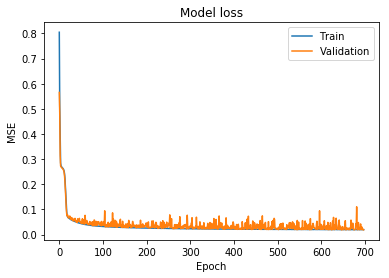

In [33]:
plt.plot(history_PLANCK.history['loss'])
plt.plot(history_PLANCK.history['val_loss'])
plt.title('Model loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [0]:
model_PLANCK.save(path+'PLANCK_model.h5')

In [0]:
# Read data set
path = "/content/drive/My Drive/DL-fisica/1 CMB/"
SET='PLANCK+HASLAM'  

freq,sigma=DataSet(SET) # cargamos num de frecuencias , std del ruido, y valor maximo del synchrotron
nu_ref=freq[0]  # frecuencia donde evaluamos el synchrotron

Signal=np.loadtxt(path+SET+'_Signal_dataset.txt')   # 10000 x len(freq)
Labels=np.loadtxt(path+SET+'_Signal_labels.txt')    # 10000 x 4 params (A_cmb,A_s,beta_s,A_d)

In [0]:
from sklearn.preprocessing import StandardScaler, scale

scaler_PLANCK_HASLAM_X = StandardScaler().fit(Signal)
scaler_PLANCK_HASLAM_y = StandardScaler().fit(Labels)

Signal = scaler_PLANCK_HASLAM_X.transform(Signal)
Labels = scaler_PLANCK_HASLAM_y.transform(Labels)

In [40]:
# 1.1 Start obtaining your models with a NN
model_PLANCK_HASLAM = models.Sequential()
model_PLANCK_HASLAM.add(layers.Dense(15,activation="sigmoid",input_shape = (Signal.shape[1],)))
model_PLANCK_HASLAM.add(layers.Dense(5,activation="sigmoid"))
model_PLANCK_HASLAM.add(layers.Dense(Labels.shape[1]))

model_PLANCK_HASLAM.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 15)                165       
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 80        
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 24        
Total params: 269
Trainable params: 269
Non-trainable params: 0
_________________________________________________________________


In [41]:
model_PLANCK_HASLAM.compile(optimizer = optimizers.Adadelta(),loss="mse")
history_PLANCK_HASLAM = model_PLANCK_HASLAM.fit(Signal,Labels,batch_size = 2**8,epochs = 1000,validation_split = 0.15,callbacks=[callbacks.EarlyStopping(patience = 50)])

Train on 85000 samples, validate on 15000 samples
Epoch 1/1000
85000/85000 [==============================] - 1s 6us/step - loss: 1.0032 - val_loss: 0.8321
Epoch 2/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.6654 - val_loss: 0.5695
Epoch 3/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.5314 - val_loss: 0.5122
Epoch 4/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.4921 - val_loss: 0.4816
Epoch 5/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.4619 - val_loss: 0.4506
Epoch 6/1000
85000/85000 [==============================] - 0s 6us/step - loss: 0.4319 - val_loss: 0.4216
Epoch 7/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.4072 - val_loss: 0.4009
Epoch 8/1000
85000/85000 [==============================] - 0s 6us/step - loss: 0.3904 - val_loss: 0.3871
Epoch 9/1000
85000/85000 [==============================] - 0s 5us/step - loss: 0.3786 - val_loss: 0.3

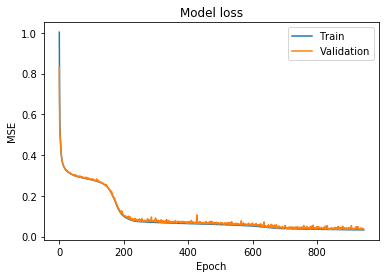

In [42]:
plt.plot(history_PLANCK_HASLAM.history['loss'])
plt.plot(history_PLANCK_HASLAM.history['val_loss'])
plt.title('Model loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [0]:
model_PLANCK_HASLAM.save(path+'PLANCK_HASLAM_model.h5')

# Ejercicio 1.2 
Con una simulación realista (Datos/Data+SET+.fits) donde sabemos cada una de las componentes, comprueba tus resultados y comenta qué efecto tiene añadir frecuencias bajas a la estimación de tus parámetros. Visualizad los mapas que obtendríais con la red y los de verdad (Datos/Params+SET+.fits) y evaluad las diferencias. 

**(3 puntos)**

In [0]:
from keras.models import load_model

path = "/content/drive/My Drive/DL-fisica/1 CMB/"
model_PLANCK = load_model(path+'PLANCK_model.h5')
model_PLANCK_HASLAM = load_model(path+'PLANCK_HASLAM_model.h5')

In [12]:
# Cargamos con healpy los datos simulados 
SET='PLANCK'
freq,sigma=DataSet(SET) # cargamos num de frecuencias , std del ruido, y valor maximo del synchrotron
nu_ref=freq[0]  # frecuencia donde evaluamos el synchrotron

nmaps=np.arange(0,len(freq))
Datos=hp.read_map(path+'Datos/Data'+SET+'.fits',nmaps,verbose=False,dtype=np.float64)

# Los parametros que se han usado para generar estos datos son: 
True_params=hp.read_map(path+'Datos/Params'+SET+'.fits',(0,1,2,3),verbose=False,dtype=np.float64)      

# Accedemos a los mapas frecuenciales y los parametros se acceden con Datos[i], True_params[i]

/usr/local/lib/python2.7/dist-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


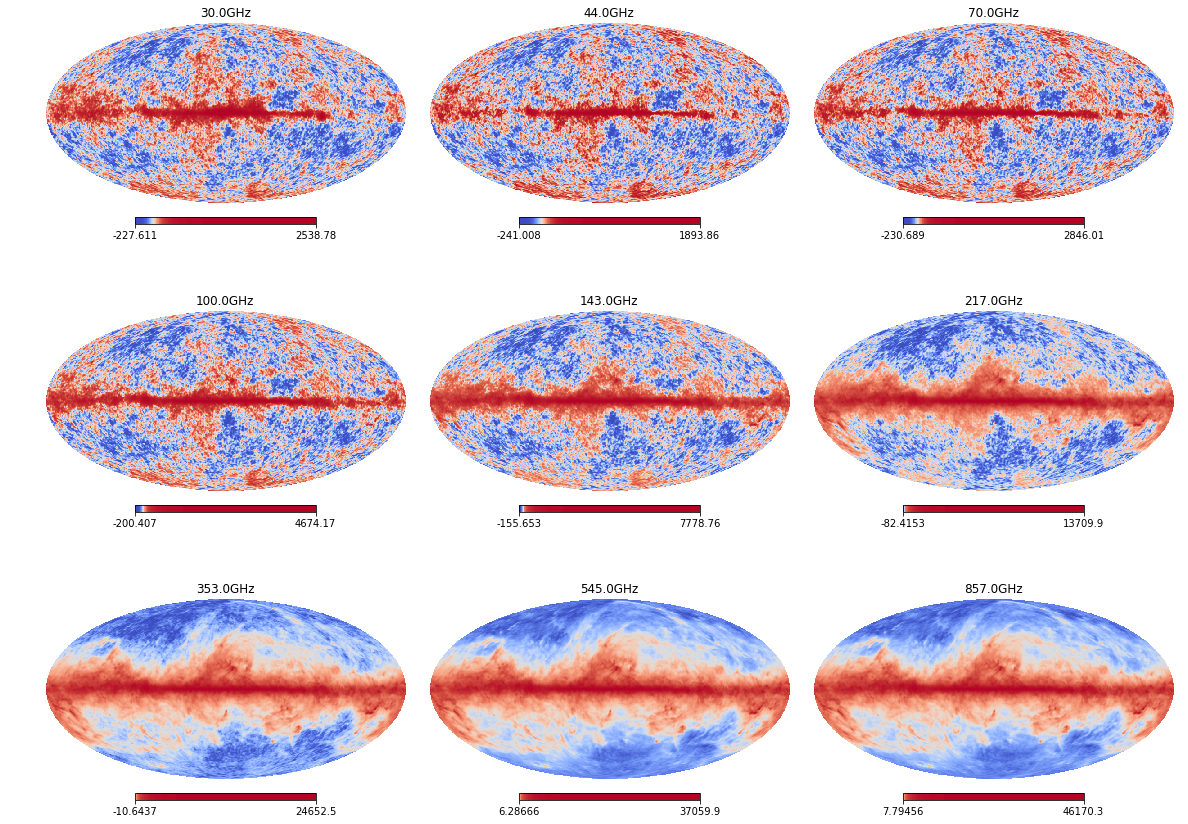

In [0]:
# Visualizamos los datos
plt.figure(0,figsize=(16,12))
if SET == 'PLANCK': n=3
if SET == 'PLANCK + HASLAM': n=4
if SET == 'PLANCK + HASLAM +QUIJOTE': n=5
for i in range(len(freq)):
    hp.mollview(Datos[i],sub=(n,3,i+1),norm='hist',title=str(freq[i])+'GHz',cmap=cmap)

In [0]:
# 1.2 Make predictions with your models and compare results
# and make a quantitative evaluation of your prediction (ex. correlation coefficient, mse,...)
#scaled_Data = scaler_PLANCK.transform(Datos.T)
Params_pred_scaled = model_PLANCK.predict(scaler_PLANCK_X.transform(Datos.T))
Params_pred = scaler_PLANCK_y.inverse_transform(Params_pred_scaled)

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mse_score_PLANCK = mean_squared_error(True_params.T,Params_pred,multioutput='raw_values')
params = ['A_cmb','A_d','A_s','B_s']



for i in range(len(params)):
  print('MSE for '+params[i]+' is: '+str(mse_score_PLANCK[i]))

MSE for A_cmb is: 17.723327915826864
MSE for A_d is: 182.1268891318457
MSE for A_s is: 0.028731607868173536
MSE for B_s is: 109224.9665699852


In [36]:
from scipy.stats import pearsonr
import pandas as pd

for i in range(4):
  print(np.corrcoef(True_params.T[:,i],Params_pred[:,i])[0,1])

0.9992533642378334
0.9977448465346518
0.12887457782915165
0.9893033678989593


In [0]:
Params_pred[:,i]

array([9939.662, 9939.662, 9939.662, ..., 9939.662, 9939.662, 9939.662],
      dtype=float32)

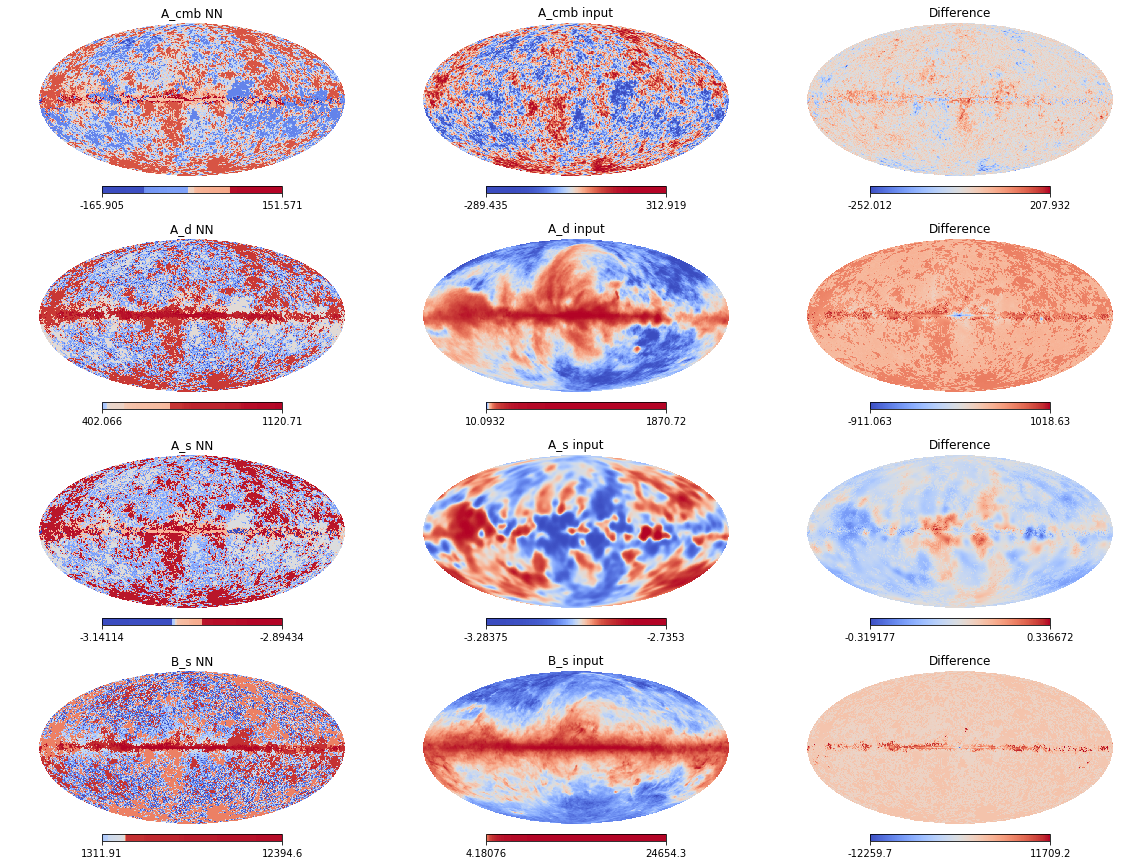

In [24]:
# Visualize the prediciton and input maps:
plt.figure(0,figsize=(16,12))
titles = ['A_cmb','A_d','A_s','B_s']

# Example first parameter: 
# Use hp.mollview to visualize the maps and their differences:
j = 0
for i in range(4):  
  hp.mollview(Params_pred[:,i],cmap=cmap,sub=(4,3,1+j),title=titles[i]+' NN',norm='hist')
  hp.mollview(True_params[i],cmap=cmap,sub=(4,3,2+j),title=titles[i]+' input',norm='hist')
  hp.mollview(Params_pred[:,i]-True_params[i],cmap=cmap,sub=(4,3,3+j),title='Difference')
  j = j + 3

In [0]:
# Cargamos con healpy los datos simulados 
SET='PLANCK+HASLAM'
freq,sigma=DataSet(SET) # cargamos num de frecuencias , std del ruido, y valor maximo del synchrotron
nu_ref=freq[0]  # frecuencia donde evaluamos el synchrotron

nmaps=np.arange(0,len(freq))
Datos=hp.read_map(path+'Datos/Data'+SET+'.fits',nmaps,verbose=False,dtype=np.float64)

# Los parametros que se han usado para generar estos datos son: 
True_params=hp.read_map(path+'Datos/Params'+SET+'.fits',(0,1,2,3),verbose=False,dtype=np.float64)      

# Accedemos a los mapas frecuenciales y los parametros se acceden con Datos[i], True_params[i]

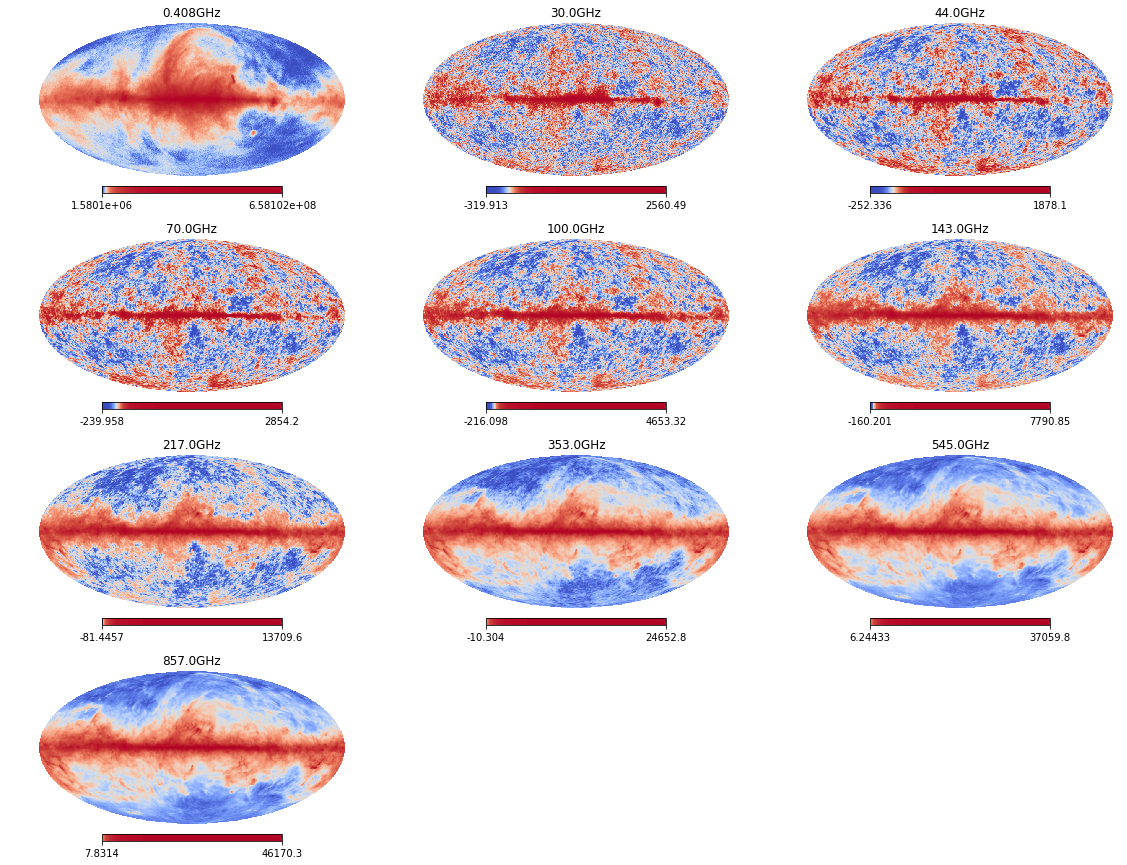

In [45]:
# Visualizamos los datos
plt.figure(0,figsize=(16,12))
if SET == 'PLANCK': n=3
if SET == 'PLANCK+HASLAM': n=4
if SET == 'PLANCK+HASLAM +QUIJOTE': n=5
for i in range(len(freq)):
    hp.mollview(Datos[i],sub=(n,3,i+1),norm='hist',title=str(freq[i])+'GHz',cmap=cmap)

In [0]:
# 1.2 Make predictions with your models and compare results
# and make a quantitative evaluation of your prediction (ex. correlation coefficient, mse,...)
#scaled_Data = scaler_PLANCK.transform(Datos.T)
Params_pred_scaled = model_PLANCK_HASLAM.predict(scaler_PLANCK_HASLAM_X.transform(Datos.T))
Params_pred = scaler_PLANCK_HASLAM_y.inverse_transform(Params_pred_scaled)

In [47]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mse_score_PLANCK_HASLAM = mean_squared_error(True_params.T,Params_pred,multioutput='raw_values')
params = ['A_cmb','A_d','A_s','B_s']



for i in range(len(params)):
  print('MSE for '+params[i]+' is: '+str(mse_score_PLANCK_HASLAM[i]))

MSE for A_cmb is: 71.97010570035296
MSE for A_d is: 204801787537959.22
MSE for A_s is: 0.04339860755465008
MSE for B_s is: 64389.59867675906


In [48]:
from scipy.stats import pearsonr
import pandas as pd

for i in range(4):
  print(np.corrcoef(True_params.T[:,i],Params_pred[:,i])[0,1])

0.9934187716032274
0.9831348521845581
0.3844322043304958
0.9965304703478844


In [0]:
# Visualize the prediciton and input maps:
plt.figure(0,figsize=(16,12))
titles = ['A_cmb','A_d','A_s','B_s']

# Example first parameter: 
# Use hp.mollview to visualize the maps and their differences:
j = 0
for i in range(4):  
  hp.mollview(Params_pred[:,i],cmap=cmap,sub=(4,3,1+j),title=titles[i]+' NN',norm='hist')
  hp.mollview(True_params[i],cmap=cmap,sub=(4,3,2+j),title=titles[i]+' input',norm='hist')
  hp.mollview(Params_pred[:,i]-True_params[i],cmap=cmap,sub=(4,3,3+j),title='Difference')
  j = j + 3

In [0]:
# 1.3  Comment what are the differences of both data sets


# Ejercicio 2. 
Para el caso PLANCK+HASLAM+QUIJOTE mandad vuestros resultados a la competición de Kaggle: https://www.kaggle.com/c/component-separation-with-nn. Podéis mandar tantos como queráis.

**(3 puntos)**